## 라이브러리 로드, 드라이브 마운트

- 주의 : 코랩 환경에서 나눔고딕 폰트로 한국어 시각화 시 설치 코드 최초 1회 실행 후 런타임 재시작 필요. 런타임 재시작 이후에는 주석 처리 후 실행하지 않음

In [ ]:
# # 코랩 환경에서 한국어 시각화
# # 최초 1회 실행 후 런타임 재시작, 이후에는 실행하지 않음

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.5 MB/s eta 0:00:00


In [ ]:
# 라이브러리 로드
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from pyvis import network as net
from IPython.core.display import display, HTML
import itertools
import gensim
from gensim.models import Word2Vec

## colab에서 형태소 분석기 mecab (konlpy) 사용 환경 구축


In [ ]:
 ! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 8.74 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
 cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
 !bash install_mecab-ko_on_colab_light_220429.sh

Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 39.7 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-06-14 11:10:17--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?response-content-disposition=attachment%3B%20filename%3D%22mecab-0.996-ko-0.9.2.tar.gz%22&response-content-encoding=None&AWSAccessKeyId=

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

## 데이터 로드

In [ ]:
#도서 특성 상의 불용어가 존재 ex)책 : 특정 책의 워드클라우드를 생성함에 있어 굳이 필요하지 않은 단어
stopwords = ['를', '은', '이', '가']

#시각화 옵션 설정, 엣지 최소값
Min_Edge_Num = 1

In [ ]:
data = pd.read_json('/content/drive/MyDrive/빅데온탑걸즈/데이터/book_review_all.json')
get_review_count = lambda x: len(x)
data['review_count'] = data['review'].apply(get_review_count) #리뷰 개수 열
data.head()

,category,title,author,review,review_count
0,소설,돌연한 출발,프란츠 카프카,"[얼마나 재밌을지 기대되요, 표지도 너무 이쁘고 책의날 카프카를 읽을수 있었네요, ...",110
1,소설,메리골드 마음 세탁소,윤정은,"[마음이 힐링 되는 느낌이에요, 매우만족합니다\n추천드려요, 저에게도 필요해요\n마...",191
2,소설,스즈메의 문단속,신카이 마코토,"[영화랑 또 다른 매력이 느껴져서 좋아요!!, 아이들이 재미있게 보네요, 너무 재미...",527
3,소설,2023 제14회 젊은작가상 수상작품집,이미상,"[재미있게 읽었습니다, 문학동네가 배가 부른걸까?\n그래도 대상받은것이라 인내심을 ...",91
4,소설,불편한 편의점(40만부 기념 벚꽃 에디션),김호연,"[읽다보니 시간 잘가고 재밌어요, 순식간에 읽어 내려감, 사람과 사람간의 얘기가 좋...",2905


In [ ]:
#리뷰가 500개 이상인 경우
for i in data[data['review_count']>500].index:
  print(i, data['category'][i])
  print(data['title'][i], '\n')

2 소설
스즈메의 문단속 

4 소설
불편한 편의점(40만부 기념 벚꽃 에디션) 

5 소설
아버지의 해방일지 

8 소설
불편한 편의점 2(단풍 에디션) 

10 소설
모순 

12 소설
세상의 마지막 기차역(리커버 에디션) 

14 소설
참을 수 없는 존재의 가벼움 

19 소설
데미안 

20 소설
오늘 밤, 세계에서 이 사랑이 사라진다 해도 

21 소설
인간 실격 

22 소설
멋진 신세계 

27 소설
이토록 평범한 미래 

28 소설
달러구트 꿈 백화점(레인보우 에디션) 

29 소설
하얼빈 

31 소설
어서 오세요, 휴남동 서점입니다 

36 소설
작별인사 

37 소설
우리가 빛의 속도로 갈 수 없다면 

38 소설
파친코 1 

40 소설
노르웨이의 숲 

41 소설
달러구트 꿈 백화점 2(레인보우 에디션) 

42 소설
미드나잇 라이브러리(평행우주 에디션) 

46 소설
호밀밭의 파수꾼 

47 소설
동물농장 

50 시/에세이
당신은 결국 무엇이든 해내는 사람(10만 부 기념 특별 리커버 에디션) 

58 시/에세이
잘했고 잘하고 있고 잘 될 것이다(스페셜 리미티드 에디션) 

60 시/에세이
꽃을 보듯 너를 본다 

73 시/에세이
잘 살고 싶은 마음이 어렵게 느껴질 때 

74 시/에세이
바다는 잘 있습니다 

89 시/에세이
여행의 이유 

90 시/에세이
언어의 온도(170만부 기념 에디션) 

98 시/에세이
죽고 싶지만 떡볶이는 먹고 싶어 

105 인문
만일 내가 인생을 다시 산다면(30만 부 기념 리커버 에디션) 

111 인문
지적 대화를 위한 넓고 얕은 지식 1 

116 인문
사피엔스 

119 인문
공정하다는 착각 

122 인문
지적 대화를 위한 넓고 얕은 지식: 제로 편 

130 인문
당신이 옳다 

132 인문
내가 틀릴 수도 있습니다 

138 인문
소크라테스 익스프레스 

142 인문
정의란 무엇인가 

145 인문
역사의 쓸모 

157 가정/육아
어떻게 말해줘야 할까 

187 가정/육아
못 참는 아이

## 상위 단어 간 공기(co-occurence) 빈도 인접 행렬(Adjacent Matrix)을 생성하여, 단어 간 관계에 대한 네트워크 시각화 분석

- 빈도에  기반하여, 한 리뷰 내에 함께 등장한 단어 간 연관을 부여. 두 단어가 동시에 등장한 리뷰가 많다면, 두 단어는 연관이 있는 단어로 간주한다. 작가의 이름과 '기대'라는 단어가 함께 자주 등장했다면, 독자들은 작가로 인해 책에 대한 기대가 높음을 알 수 있다.
- 빈도를 기반으로 인접행렬을 생성하되, 실질적 연관 강화를 위해 word2vec 기법을 활용해 연관의 정도를 강화한다.

In [ ]:
def make_noun_list(sentence_list, stopwords):
  nouns = [mecab.nouns(rv) for rv in sentence_list]
  for j in range(len(nouns)):
      nouns[j] = [noun for noun in nouns[j] if noun not in stopwords and len(noun)>1]
  return nouns

In [ ]:
# 상위 빈도 max_noun_num개 단어 추출
def get_frequent_words( nouns_list, max_noun_num ):
    total_noun_list = []
    for paragraph_nouns in nouns_list:
        total_noun_list.extend(paragraph_nouns)

    counted_nouns = Counter(total_noun_list)  ### 모든 명사들의 빈도 Dict
    top_nouns = dict(counted_nouns.most_common(max_noun_num))  ### 고빈도 상위 max_noun_num 수만큼 {단어:빈도, 단어:빈도, ...} 추출

    return top_nouns

In [ ]:
# 인접행렬 생성 ==> 같은 paragraph에 등장하면 인접으로 간주 ==> 행렬의 각 값은 빈도
def get_adjacency_matrix( paragraph_nouns_list, word2id, max_noun_num):
    adjacency_matrix = np.zeros((max_noun_num, max_noun_num), int)
    for paragraph_nouns in paragraph_nouns_list:
        for w, i in word2id.items(): # 단어 w와 연관된 단어가 같은 단위(리뷰) 내에 얼마나 있는지
            if w in paragraph_nouns:
                for noun, j in word2id.items():
                    if i != j and noun in paragraph_nouns:
                        adjacency_matrix[i][j] += 1
    return adjacency_matrix

In [ ]:
# 해당 도서의 리뷰로 학습 시킨 word2vec 모델에서, similarity가 있는 단어의 경우, 실질적 연관으로 간주하고 기존 빈도에 가중치를 부여
def wv_adjacency_matrix(noun_list, adjacency_matrix, id2word, w=1):
  wv_model = Word2Vec(sentences=noun_list, window=4, min_count=5, workers=3, sg=1)
  for i in range(len(id2word)):
    for j in range(len(id2word)):
      if i<j:
        similar_list = dict(wv_model.wv.most_similar(id2word[i]))
        if id2word[j] in list(similar_list.keys()):
          adjacency_matrix[i][j] = round(adjacency_matrix[i][j]*(1+similar_list[id2word[j]])*w)
          adjacency_matrix[j][i] = round(adjacency_matrix[j][i]*(1+similar_list[id2word[j]])*w)
  return adjacency_matrix

In [ ]:
# 그래프 생성 함수
def create_word_association_graph( adjacency_matrix, id2word, max_noun_num):
    noun_key_list = [id2word[w] for w in range(max_noun_num)]
    noun_key_list
    if len(noun_key_list) == 0 : return

    df = pd.DataFrame(adjacency_matrix, index=noun_key_list, columns=noun_key_list)

    prob_G = nx.from_pandas_adjacency(df)

    ### 최소 연결 수 미만 노드 제거
    remove_nodes = [node for node, degree in dict(prob_G.degree()).items() if degree < Min_Edge_Num]
    prob_G.remove_nodes_from(remove_nodes)

    ### 분리된 작은 그래프 제거
    centrality = nx.algorithms.centrality.degree_centrality(prob_G)
    if len(centrality) < 2: return
    max_node = max(centrality.items(), key = lambda k : k[1])[0]
    remove_nodes = []
    for nd in prob_G.nodes():
         if not nx.has_path( prob_G, max_node, nd ) :
             remove_nodes.append(nd)
    prob_G.remove_nodes_from(remove_nodes)

    ######### 속성 변경 ###########
    centrality = nx.algorithms.centrality.degree_centrality(prob_G)
    if len(centrality) < 2: return

    maxv = max(centrality.items(), key = lambda k : k[1])[1]
    minv = min(centrality.items(), key = lambda k : k[1])[1]

    baseColorList = ['#FFAAFF','#FEA443','#F2CB05','#4EBA6F','#0597F2']
    baseColorList_len = 5
    nodeSizeList, nodeColorList = [], []
    for n, v in centrality.items():
        nodeSizeList.append(round((v-minv)/(maxv-minv+0.001) * 2500)+500)
        color_x = round( (v-minv)*0.9/(maxv-minv+0.001) * baseColorList_len )
        if color_x == baseColorList_len : color_x = baseColorList_len - 1
        nodeColorList.append(baseColorList[color_x])

    weights = nx.get_edge_attributes(prob_G,'weight').values()
    maxw = max(weights)
    minw = min(weights)
    edgeWidthList= []
    for w in weights:
        edgeWidthList.append(round((w-minw)/(maxw-minw+0.001)*3)+1)

    ##############################
    nodeFontSizeList = [16] * len(prob_G.nodes)

    ### 그래프 이미지 영역 크기
    f = plt.gcf()
    f.set_size_inches(10,10)
    pos = nx.spring_layout(prob_G)

    ### 그리기
    nx.draw(prob_G, font_family='NanumBarunGothic', font_size=16, pos=pos, #nx.spring_layout(prob_G),
            node_size = nodeSizeList, node_color = nodeColorList,
            width=edgeWidthList, edge_color='gray',
            alpha=0.9, with_labels=True, ax=f.add_subplot(111) )

In [ ]:
##### 입력: data, 출력 : 네트워크 그래프
def draw_word_association_graph(data, stopwords, index, max_noun_num, remove_title=True):

    review = data['review'][index]
    title = data['title'][index]
    author = data['author'][index]
    print('도서명 :', title)
    print('저자명 :', author, '\n')

    if remove_title == True:
      stopwords += mecab.nouns(title)

    # 명사 추출
    nouns_list = make_noun_list(review, stopwords)

    # 고빈도 명사 추출
    top_nouns = get_frequent_words( nouns_list, max_noun_num )

    # 명사==>순번, # 순번==>명사
    word2id = {w: i for i, w in enumerate(top_nouns.keys())}
    id2word = {i: w for i, w in enumerate(top_nouns.keys())}

    # 인접행렬 생성
    adjacency_matrix = get_adjacency_matrix( nouns_list, word2id, max_noun_num )

    # word2vec 관련어 빈도 강화
    adjacency_matrix = wv_adjacency_matrix( nouns_list, adjacency_matrix, id2word, w=1 )

    #그래프 생성
    create_word_association_graph(adjacency_matrix, id2word, max_noun_num)

도서명 : 돌연한 출발
저자명 : 프란츠 카프카 



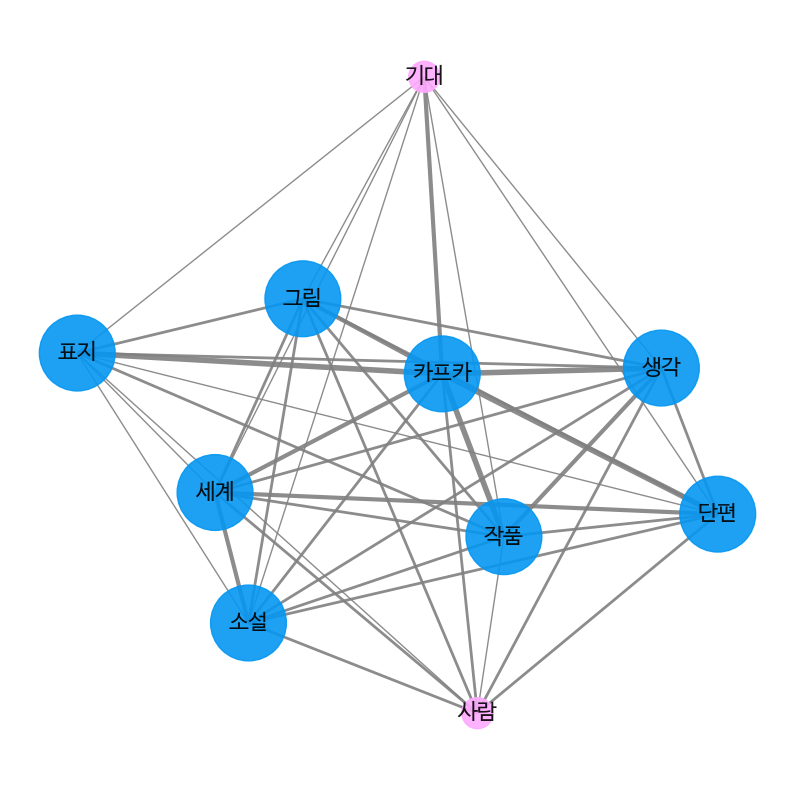

In [ ]:
draw_word_association_graph( data, stopwords, 0, 10)
# 독자들이 기대하는 가장 큰 이유 : 카프카임을 알 수 있다.

도서명 : 스즈메의 문단속
저자명 : 신카이 마코토 



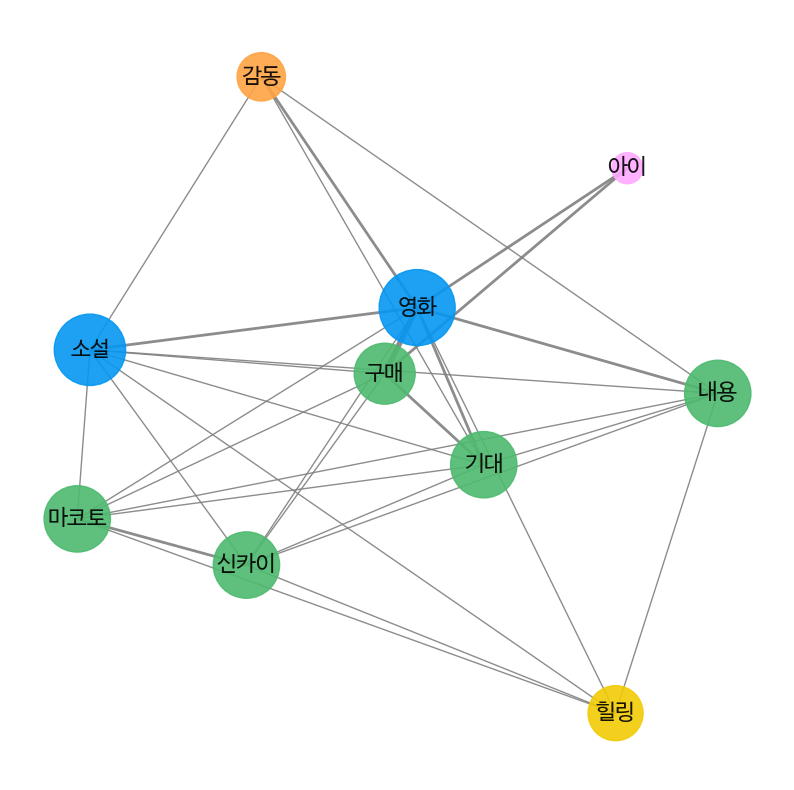

In [ ]:
# 구매와 가장 깊은 연관을 맺고 있는 키워드는 영화이다.
# 즉, 독자들의 구매가 영화로부터 이어짐을 유추할 수 있다.
draw_word_association_graph( data, stopwords, 2, 10)

In [ ]:
# 리뷰 문장 휴리스틱 분석
# '구매'라는 단어가 들어간 리뷰를 보았을 때, 실제로 영화가 도서 구매로 이어졌다는 댓글이 많다.
for sentence in data['review'][2]:
  if '구매' in sentence:
    print(sentence, '\n')

아이랑 영화 보고 구매해줬어요
책으로 영화에서 느끼지 못한 부분까지 챙길수있다네요 

초등학생 딸과 영화를 보고나서 책을 구매했고 매일 같이 소리내어 읽고 있습니다. 글로 읽으니 새롭고 더 재밌어요! 

영화보고 아이가 너무 보고 싶다고 하여 구매했는데
재미있게 잘 읽고 있습니다 

책먼저조려고 구매했어요 

영화로 2번보고 책도 구매합니다
딸 아이도 저도 좋아요 

아이와 영화를 보고 책까지 사달라고해서 구매합니다. 

아이가 영화보고 사달라고해서 구매했어요 

영화보고 구매했어요 너므 재밌습니다 

영화보고 책도 읽고싶어서 구매했어요 

영화보고 책도 구매했습니다. 재미있어요~ 

영화보고나서 구매했어요! 

영화보고 딸래미가 사달라고 해서 구매했어요! 

영화를 재밌게봐서 책도 구매합니다 

영화관에서 아직 못봐서 구매해서 읽어보려구요 

영화보고 구매합니다. 기대되네요 

영화보고 원작도 읽어보고 싶어서 구매했어요 

영화 보고 책으로도 읽고 싶어져서 구매했습니다. 

스즈메의 문단속을 영화관에서 본 뒤로 푹 빠지게 되어서 소설책이 있다는 걸 듣고 바로 구매했습니다!! 영화로 나온 게 소설로도 나오는 경우가 있고 그 반대인 경우가 있었는데 애니를 먼저 보고 책을 읽으려고 하면 재밌지만 꾸준히 안 읽는 경향이있어서 좀 고민하긴 했었습니다 ㅎㅎ 그래도 안 사면 후회할 것 같아서 바로 구매..😊 오늘 배송받아서 아직 펴보지도 않았지만 그래도 영화를 재밌게 봤으니 책도 재미있지 않을까 싶어요!! 

신카이 마코토 님의 애니메이션 좋아해서, 책도 구매했습니다.♥ 

신카이 마코토 감독의 신작 기대되어서 구매했습니다. 

영화 보고나서 책으로도 읽고 싶어 구매합니다.영화도 재미있었지만 책도 많이 기대됩니다. 

너의이름은 작가님이기도하고 영화보기전 아이와 읽어보려 구매했어요. 

영화보고 재밌어서 소설로도 구매합니다 

영화 보고 책도 구매해요~^^ 

요즘 핫한 영화 원작이라 구매했어요 기대되네요 

영화보기전에 먼저 글로 읽고 싶어서 구매한책 

영화를 보고난

도서명 : 슬램덩크 1: 강백호(신장재편판)
저자명 : Takehiko Inoue 



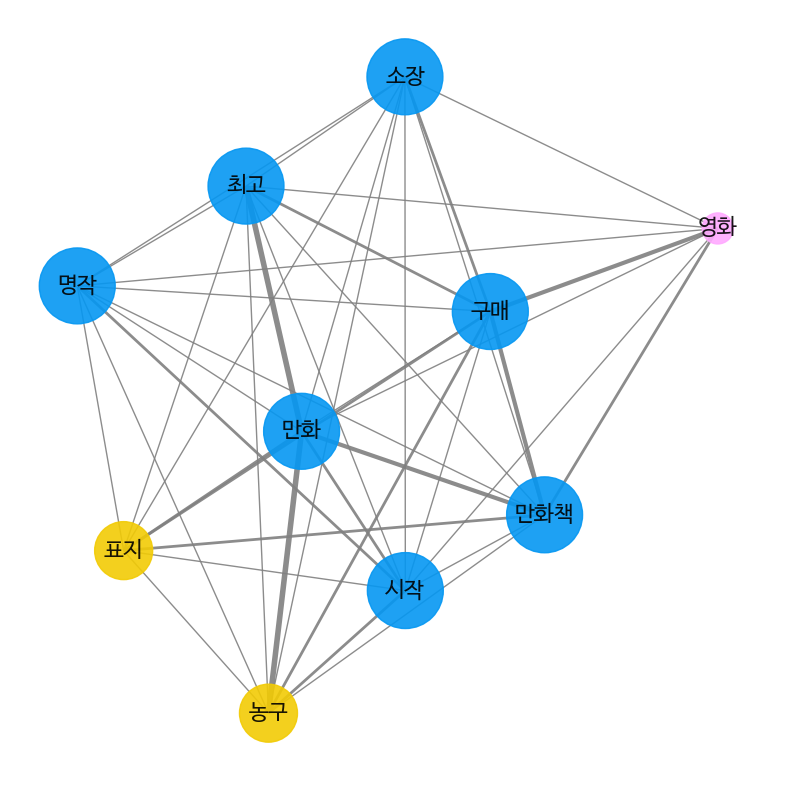

In [ ]:
# 만화라는 장르인데 최고, 농구라는 키워드와 연관이 깊으며, '구매' 키워드와 영화가 관련이 깊다. 영화 시청이 구매로 이어짐을 유추할 수 있다.
draw_word_association_graph( data, stopwords, 1231, 10)

도서명 : 쎈 고등 수학(상)(2023)
저자명 : 홍범준 



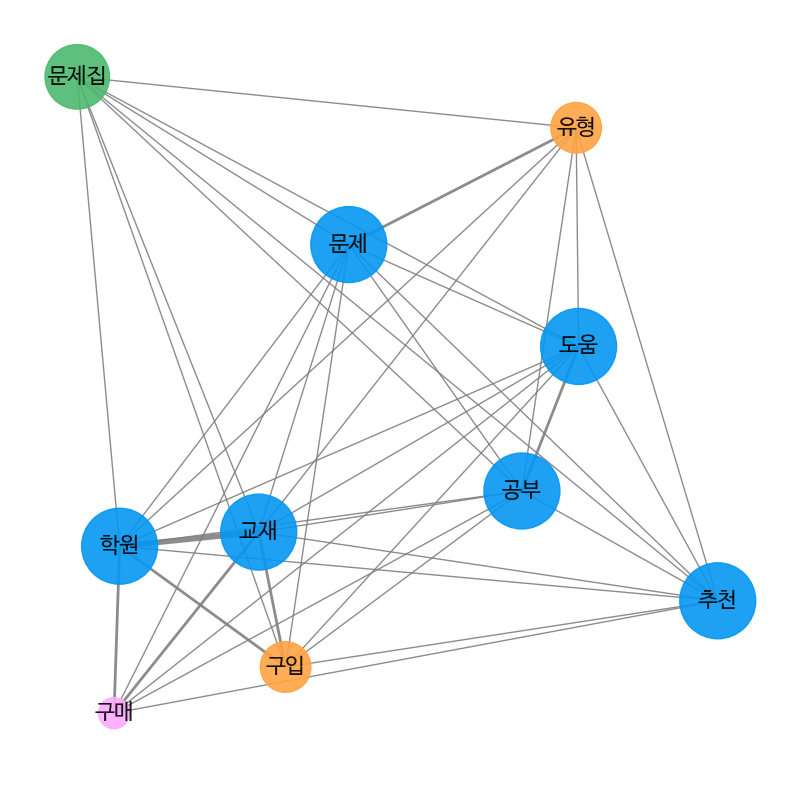

In [ ]:
# 책 구입의 계기가 학원 교재이기 때문임을 유추할 수 있다.
draw_word_association_graph( data, stopwords, 1407, 10)

도서명 : 긴긴밤
저자명 : 루리 



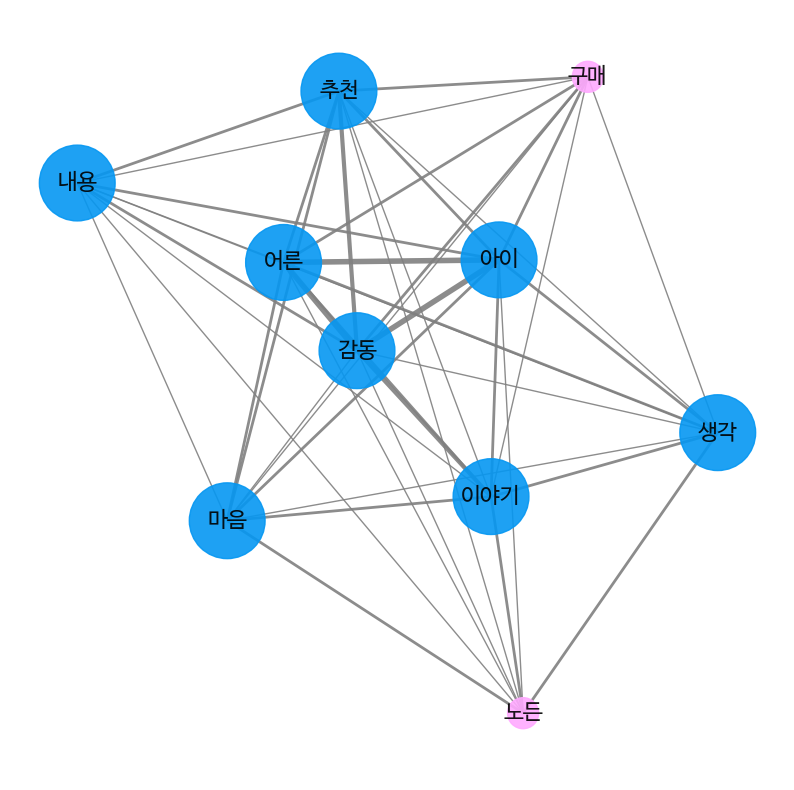

In [ ]:
# 동화책인데 어른과 아이라는 키워드의 연관이 깊다. 아이뿐 아니라 어른이 함께 볼 수 있는 내용임을 유추할 수 있고,
# 동화책의 구매자는 아이가 아니라 어른이기 때문에, 어린이 동화이지만 리뷰를 통해 반응을 분석한 결과 타깃을 어른층으로 확대할 가능성을 확인한다.
draw_word_association_graph( data, stopwords, 1152, 10)

도서명 : 면역
저자명 : 필리프 데트머 



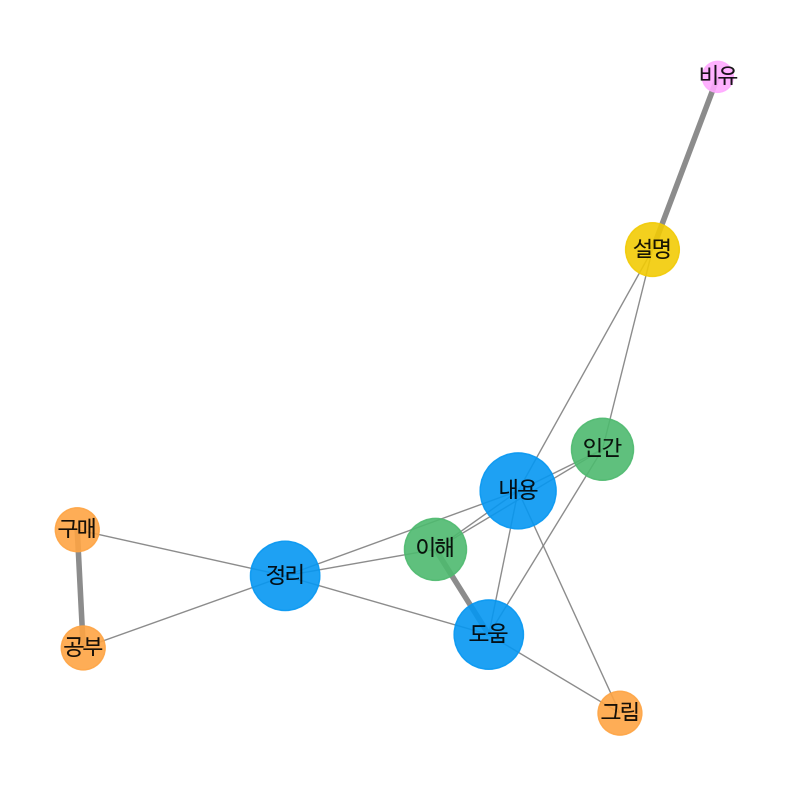

In [ ]:
# 공부를 목적으로 구매하며, 비유를 통한 설명 덕분에 이해하기에 도움이 된다는 실제 독자들의 반응을 유추할 수 있다.
draw_word_association_graph( data, stopwords, 777, 10)

도서명 : SQL 자격검정 실전문제
저자명 : 한국데이터진흥원 



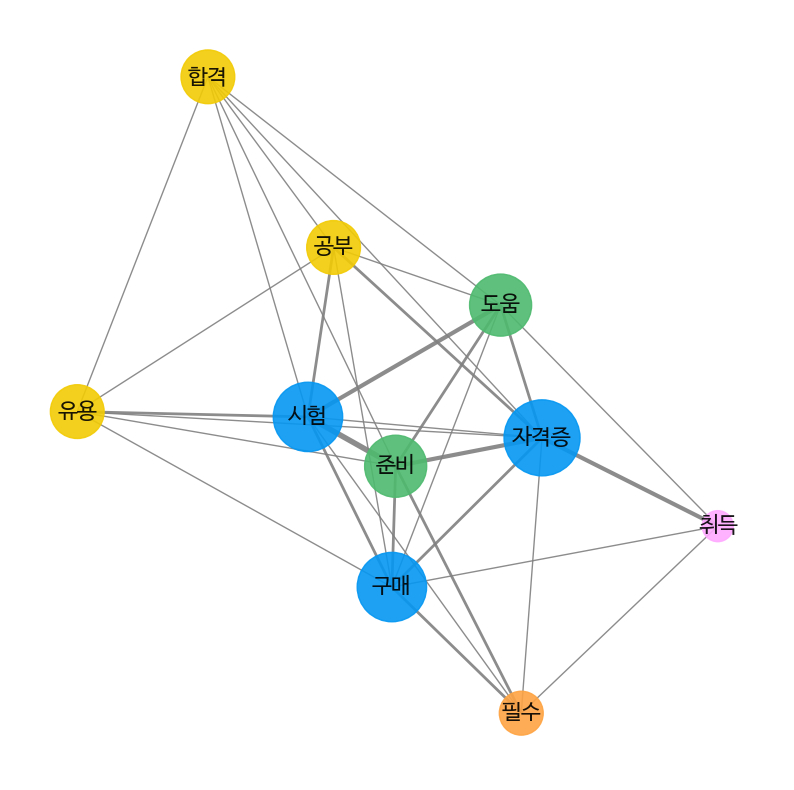

In [ ]:
# 자격증 시험 준비에 도움이 됨을 유추가능하다.
draw_word_association_graph( data, stopwords, 900, 10)

도서명 : 설득의 심리학 1(20주년 기념 개정증보판)
저자명 : 로버트 치알디니 



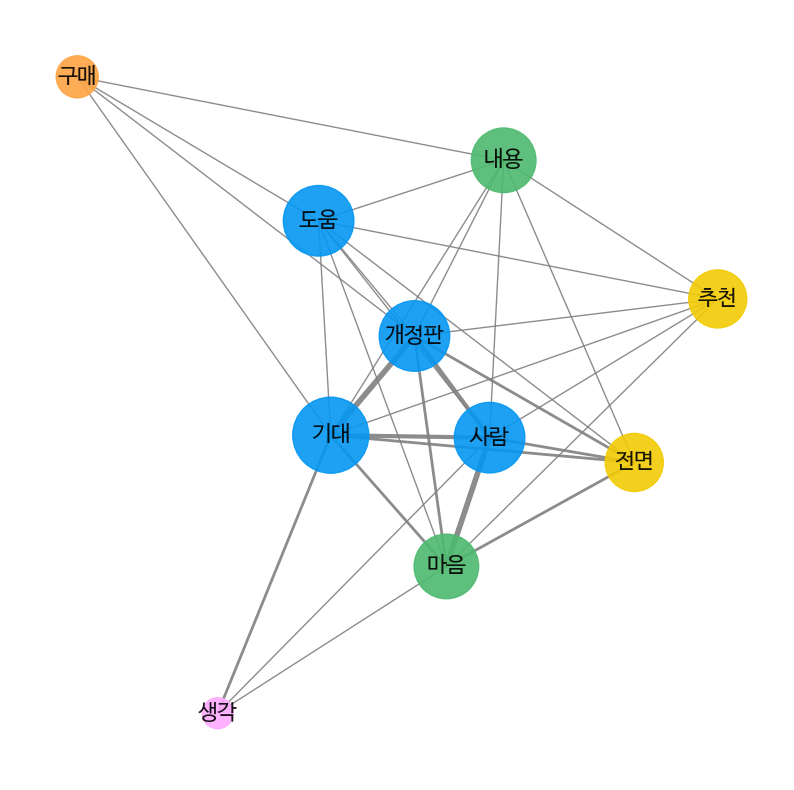

In [ ]:
# 개정판이어서 기대를 하는 독자층이 있음을 유추할 수 있다.
draw_word_association_graph( data, stopwords, 410, 10)

도서명 : 말기 암 진단 10년, 건강하게 잘 살고 있습니다
저자명 : 주마니아 



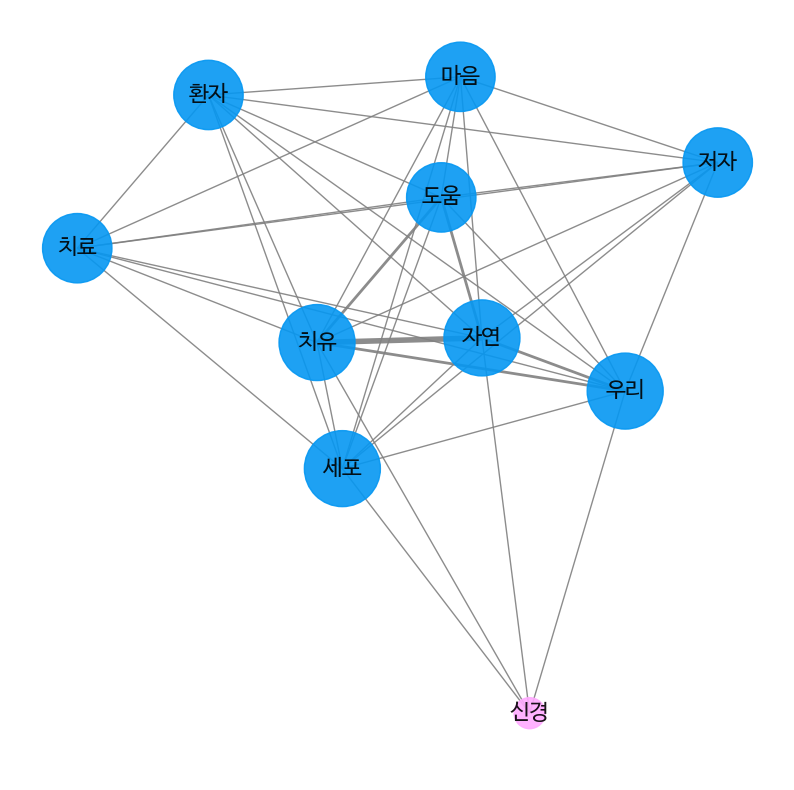

In [ ]:
# 암의 자연 치유에 관한 이야기가 키워드로 등장한다.
draw_word_association_graph( data, stopwords, 291, 10)

도서명 : 안밥모 베스트 유아식
저자명 : 이샘 



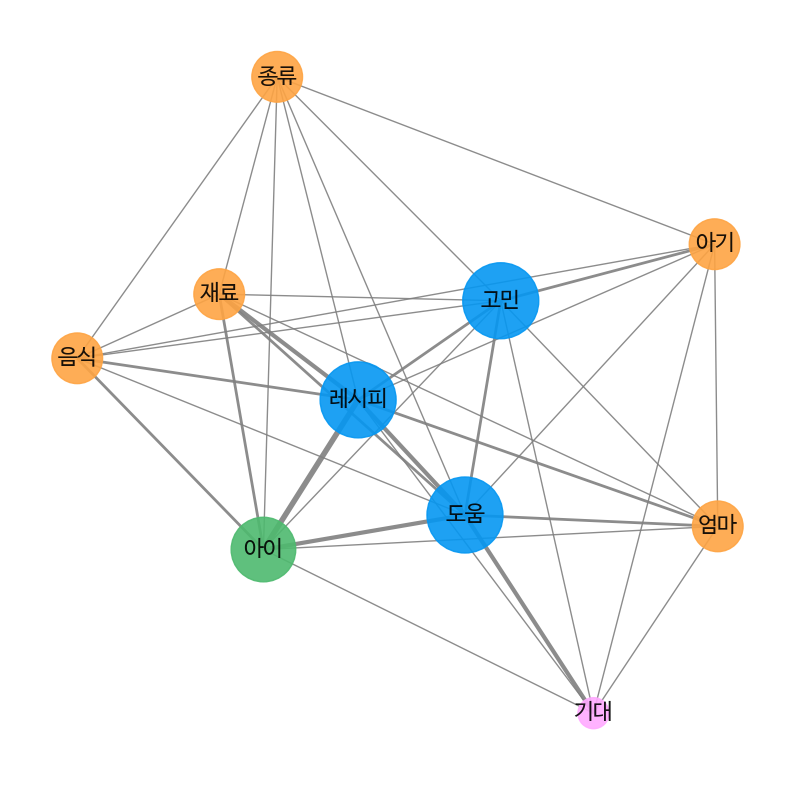

In [ ]:
# 책을 통해 도움을 받을 수 있는 부분이 아이를 위한 레시피, 재료, 고민 등임을 알 수 있다.
draw_word_association_graph( data, stopwords, 210, 10)